In [2]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import os
from copy import deepcopy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from itertools import permutations
import torch.nn.functional as F
# from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import vector
from tqdm.notebook import tqdm
import yaml

In [3]:
yaml_name='Aug16_simple.yaml'

In [4]:
base_path = os.path.dirname(os.getcwd())

full_folder_path = os.path.join(base_path,"saved_files", "fake_data")

yaml_file_path= os.path.join(base_path, "fnn_FeatureRegression", 'yamls', yaml_name)
with open(yaml_file_path, 'r') as yaml_file:
    loaded_data = yaml.load(yaml_file, Loader=yaml.SafeLoader)

# Extract the general configurations
data_name = loaded_data['data_name']
batch_size = loaded_data['batch_size']
early_stop_patience = loaded_data['early_stop_patience']
learning_rate = loaded_data['learning_rate']
Local_model=loaded_data['Local_model']
model_save_prefix=loaded_data['model_save_prefix']

# Extracting model configurations
models = loaded_data['models']
hidden_layers_list_loaded = [model['hidden_layers'] for model in models]
activation_fn_names_loaded = [model['activation_fn'] for model in models]

# Map function names back to their actual functions
activation_fn_mapping = {
    'relu': F.relu,
    'sigmoid': F.sigmoid,
    'tanh': F.tanh
}

# Convert function names to actual functions
activation_fn_list_loaded = [activation_fn_mapping[name] for name in activation_fn_names_loaded]


In [5]:
base_path = os.path.dirname(os.getcwd())

full_folder_path = os.path.join(base_path,"saved_files", "fake_data")
# data_df=pd.read_pickle(os.path.join(full_folder_path,"Aug7_1mil.pkl"))
# with open(os.path.join(full_folder_path,"Aug10_5mil.pkl"), 'rb') as f:
with open(os.path.join(full_folder_path,data_name), 'rb') as f:
    clean_data_dict = pickle.load(f)
print(clean_data_dict.keys())
numevents=len(clean_data_dict['2_phi'])
print("number of events:",numevents)

data_dict=clean_data_dict
print(data_dict.keys())

data_dict_np={}
for key in data_dict.keys():
    data_dict_np[key]=np.array(data_dict[key])

yaml_file_path= os.path.join(base_path, "fnn_FeatureRegression", 'yamls', yaml_name)


dict_keys(['event', 'genWeight', 'MET_phi', '1_phi', '1_genPartFlav', '2_phi', '2_genPartFlav', '3_phi', '3_genPartFlav', 'charge_1', 'charge_2', 'charge_3', 'pt_1', 'pt_2', 'pt_3', 'pt_MET', 'eta_1', 'eta_2', 'eta_3', 'mass_1', 'mass_2', 'mass_3', 'deltaphi_12', 'deltaphi_13', 'deltaphi_23', 'deltaphi_1MET', 'deltaphi_2MET', 'deltaphi_3MET', 'deltaphi_1(23)', 'deltaphi_2(13)', 'deltaphi_3(12)', 'deltaphi_MET(12)', 'deltaphi_MET(13)', 'deltaphi_MET(23)', 'deltaphi_1(2MET)', 'deltaphi_1(3MET)', 'deltaphi_2(1MET)', 'deltaphi_2(3MET)', 'deltaphi_3(1MET)', 'deltaphi_3(2MET)', 'deltaeta_12', 'deltaeta_13', 'deltaeta_23', 'deltaeta_1(23)', 'deltaeta_2(13)', 'deltaeta_3(12)', 'deltaR_12', 'deltaR_13', 'deltaR_23', 'deltaR_1(23)', 'deltaR_2(13)', 'deltaR_3(12)', 'pt_123', 'mt_12', 'mt_13', 'mt_23', 'mt_1MET', 'mt_2MET', 'mt_3MET', 'mt_1(23)', 'mt_2(13)', 'mt_3(12)', 'mt_MET(12)', 'mt_MET(13)', 'mt_MET(23)', 'mt_1(2MET)', 'mt_1(3MET)', 'mt_2(1MET)', 'mt_2(3MET)', 'mt_3(1MET)', 'mt_3(2MET)', 'ma

In [6]:
input_data_names_ordered = [
    ['MET_phi', 'pt_MET'], 
    ['1_phi', 'pt_1', 'eta_1', 'mass_1'], 
    ['2_phi', 'pt_2', 'eta_2', 'mass_2'], 
    ['3_phi', 'pt_3', 'eta_3', 'mass_3']
]
input_data_particle_order = ['MET', '1', '2', '3']

pair_order = ["MET_1", "MET_2", "MET_3", "1_2", "1_3", "2_3"]
used_labels2 = [
    ['deltaphi_1MET', 'mt_1MET'], 
    ['deltaphi_2MET', 'mt_2MET'], 
    ['deltaphi_3MET', 'mt_3MET'], 
    ['deltaphi_12', 'deltaeta_12'], 
    ['deltaphi_13', 'deltaeta_13'], 
    [ 'deltaphi_23', 'deltaeta_23']
]

lepton_input_ordered = input_data_names_ordered[1:]
lepton_output_ordered = used_labels2[3:]

l_input_shape=(numevents,len(lepton_input_ordered), len(lepton_input_ordered[0]))
print("events, particles, input features: ",l_input_shape)
l_input= np.empty(l_input_shape)

for i in range(len(lepton_input_ordered)):
    for j, feature in enumerate(lepton_input_ordered[i]):
        l_input[:,i,j] = data_dict_np[feature]

l_output_shape=(numevents, len(lepton_output_ordered), len(lepton_output_ordered[0]))
print("events, particle pairs, output kin. features: ",l_output_shape)
l_output= np.empty(l_output_shape)

for i in range(len(lepton_output_ordered)):
    for j, feature in enumerate(lepton_output_ordered[i]):
        l_output[:,i,j] = data_dict_np[feature]

lepton_pair_order = pair_order[3:]
lepton_particle_order = input_data_particle_order[1:]
print("lepton pair order: ", lepton_pair_order)
print("lepton particle order: ", lepton_particle_order)

events, particles, input features:  (2844237, 3, 4)
events, particle pairs, output kin. features:  (2844237, 3, 2)
lepton pair order:  ['1_2', '1_3', '2_3']
lepton particle order:  ['1', '2', '3']


In [7]:
print(l_input.shape)
pair_input_order=[(0,1),(0,2),(1,2), (1,0),(2,0),(2,1)]

output_dim=3*l_output_shape[2]
input_dim=l_input.shape[2]*6*2
# datashape=(numevents*len(pair_input_order),l_input.shape[2]*2)
datashape=(numevents,input_dim)
print("datashape",datashape)
data=np.array(np.zeros(datashape))
for i in range(len(pair_input_order)):
    combined=np.concatenate((l_input[:,pair_input_order[i][0],:],l_input[:,pair_input_order[i][1],:]),axis=1)
    # print(combined.shape)
    #add to data
    data[:,i*combined.shape[1]:(i+1)*combined.shape[1]]=combined



print("data shape",data.shape)
labels=l_output.reshape((numevents,output_dim))
print("labels shape",labels.shape)

(2844237, 3, 4)
datashape (2844237, 48)
data shape (2844237, 48)
labels shape (2844237, 6)


In [8]:
class particleDataset(Dataset):
    def __init__(self, data, labels):
        self.data=data
        self.labels=labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        return self.data[idx],self.labels[idx]


batch = 320
x_tensor = torch.from_numpy(data).float()
y_tensor = torch.from_numpy(labels).float()

# dataset=particleDataset(data,y)
dataset=TensorDataset(x_tensor,y_tensor)

train_val_data, test_data = train_test_split(dataset, test_size=0.2, random_state=41)
training_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=41)

train_loader=DataLoader(training_data, batch_size=batch, shuffle=True)
test_loader=DataLoader(test_data, batch_size=batch, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch, shuffle=True)


# train_loader=DataLoader(dataset, batch_size=batch, shuffle=True)
#make trainloader using data as x and y as labels
# trainloader=DataLoader(data, batch_size=batch, shuffle=True)
# train_dataset= 
# trainloader=DataLoader(data, batch_size=batch, shuffle=True)

In [9]:
print(len(val_loader))

1423


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class KinematicNet(nn.Module):
    def __init__(self):
        super(KinematicNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, int(input_dim*1.5))
        self.fc2 = nn.Linear(int(input_dim*1.5), int(input_dim//3))
        self.fc3 = nn.Linear(int(input_dim//3), output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

model = KinematicNet()
model.to(device)


def custom_train_loss(y_pred, y_true):
    mse_loss = torch.mean((y_pred - y_true) ** 2)

    return mse_loss
    
    

def custom_val_loss(y_pred, y_true):
    num_features = int(output_dim / 3)
    y_pred_reshaped = y_pred.reshape(-1, 3, num_features)
    y_true_reshaped = y_true.reshape(-1, 3, num_features)
    
    loss_list = []
    
    for i in range(num_features):
        y_p = y_pred_reshaped[:, :, i].flatten()
        y_t = y_true_reshaped[:, :, i].flatten()
        loss = torch.mean((y_p - y_t) ** 2)
        loss_list.append(loss.item())
    

    mse_loss = torch.mean((y_pred - y_true) ** 2)
    return loss_list, mse_loss

        
        
def l2_regularization(model, lambda_reg):
    l2_reg = 0.0
    for W in model.parameters():
        l2_reg += torch.sum(W ** 2)
    return l2_reg * lambda_reg
 
        



In [13]:
optimizer=torch.optim.Adam(model.parameters(), lr=0.0001)
# loss_fn=nn.MSELoss()


out_feats=['deltaphi', 'deltaeta']
losses_cols=['train_loss', 'val_loss', 'l2sum']+out_feats
losses_df=pd.DataFrame(columns=losses_cols)


numepochs=10000
best_loss=np.inf
for epoch in range(numepochs):
    model.train()
    train_loss=0
    l2sum=0
    for i, (x, y) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False, position=0, disable=True):
        x=x.to(device)
        y=y.to(device)
        y_pred=model(x)
        original_loss = custom_train_loss(y_pred, y)
        l2_loss = l2_regularization(model, lambda_reg=1e-9)
        l2sum+=l2_loss.item()
        # print(l2_loss)
        loss = original_loss + l2_loss

        train_loss += original_loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # train_loss=train_loss/len(train_loader)
    

    
    model.eval()
    
    feat_losses=[]
    with torch.no_grad():
        valloss=0
        for (x2, y2) in val_loader:
            x2=x2.to(device)
            y2=y2.to(device)
            y_pred2=model(x2)
            feats_loss, val_losscurr = custom_val_loss(y_pred2, y2)
            feat_losses.append(feats_loss)

            # valloss=(sum(feats_loss))/len(feats_loss)
            valloss+=val_losscurr.item()

        if valloss<best_loss:
            best_loss=valloss
            patience=10
            modelsave=deepcopy(model.state_dict())
        else:
            patience-=1
            if patience==0:
                print('early stopping')
                break

    # print(l2sum)
    l2sum=l2sum/len(train_loader)
    # print(l2sum)
    loss_strings = [f"{out_feats[i]}: {sum(feat_losses[i])/len(feat_losses[i]):.4e}" for i in range(len(out_feats))]
    loss_summary = ", ".join(loss_strings)
    losses_df.loc[epoch]=[train_loss/len(train_loader), valloss/len(val_loader),l2sum, feats_loss[0], feats_loss[1]]
    print(f"epoch: {epoch}, train: {train_loss/len(train_loader):.4e}, tot val: {valloss/len(val_loader):.4e}, {loss_summary}")


epoch: 0, train: 5.2457e-02, tot val: 4.6295e-02, deltaphi: 4.0038e-02, deltaeta: 4.4969e-02
epoch: 1, train: 4.1019e-02, tot val: 3.6779e-02, deltaphi: 3.7704e-02, deltaeta: 4.3891e-02
epoch: 2, train: 3.3055e-02, tot val: 2.9400e-02, deltaphi: 2.6545e-02, deltaeta: 2.6031e-02
epoch: 3, train: 2.6021e-02, tot val: 2.2265e-02, deltaphi: 2.2723e-02, deltaeta: 1.7904e-02
epoch: 4, train: 1.7988e-02, tot val: 1.4597e-02, deltaphi: 1.4773e-02, deltaeta: 1.7076e-02
epoch: 5, train: 1.0826e-02, tot val: 7.6418e-03, deltaphi: 7.4855e-03, deltaeta: 8.3122e-03
epoch: 6, train: 5.6285e-03, tot val: 3.7611e-03, deltaphi: 4.4969e-03, deltaeta: 3.5736e-03
epoch: 7, train: 2.6258e-03, tot val: 2.9416e-03, deltaphi: 2.8817e-03, deltaeta: 3.0360e-03
epoch: 8, train: 1.2075e-03, tot val: 7.7567e-04, deltaphi: 9.0516e-04, deltaeta: 6.7695e-04
epoch: 9, train: 6.4196e-04, tot val: 3.4918e-04, deltaphi: 3.5725e-04, deltaeta: 3.8716e-04
epoch: 10, train: 4.0634e-04, tot val: 5.1539e-04, deltaphi: 5.0169e-0

KeyboardInterrupt: 

ycurr shape before reshape (568848, 3)
ycurr shape after reshape (1706544, 1)
ycurr shape before reshape (568848, 3)
ycurr shape after reshape (1706544, 1)


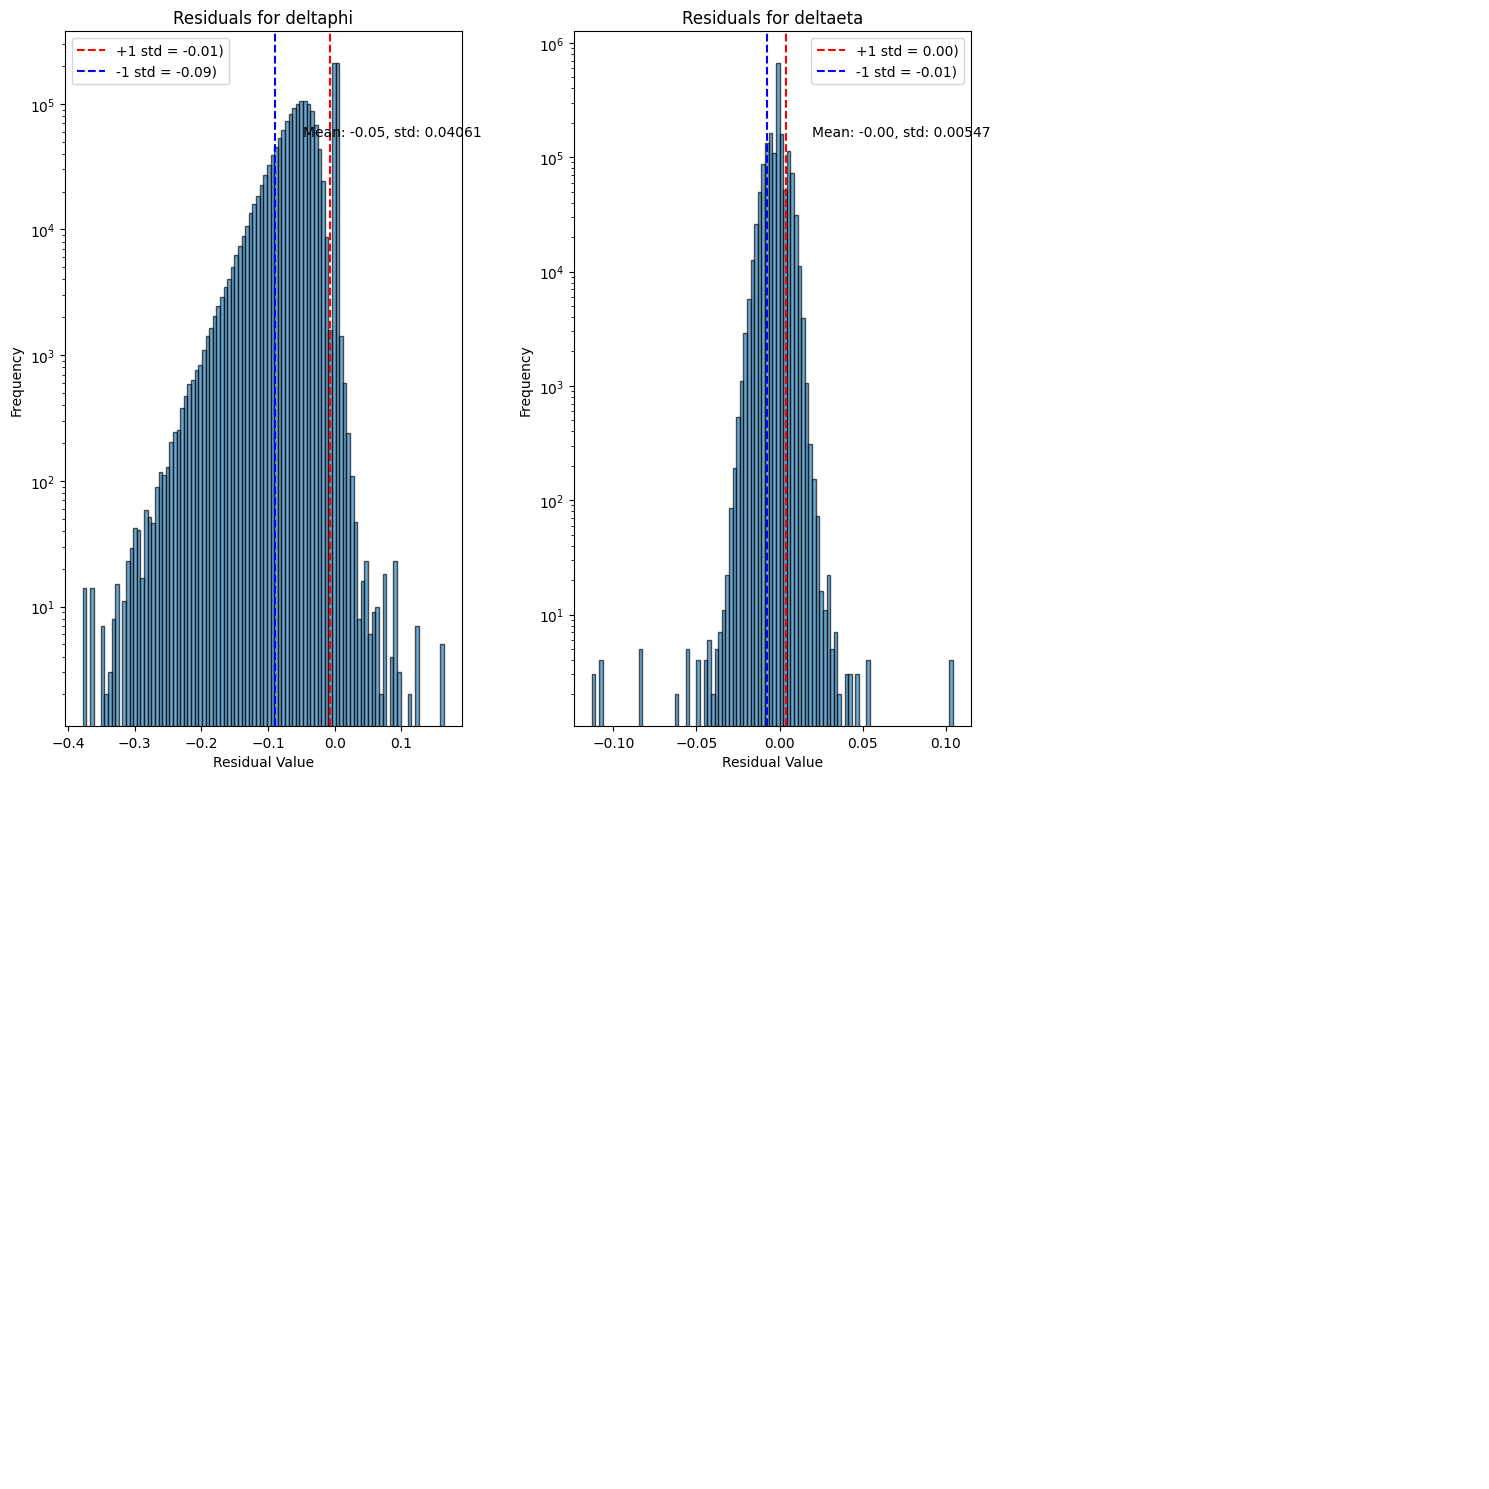

In [15]:
# plotting histogram
# ['deltaphi_12', 'deltaeta_12'],
out_feats=['deltaphi', 'deltaeta']
modeltest= KinematicNet()
modeltest.load_state_dict(modelsave)
modeltest.to(device)

residuals=np.array([])
y_total=np.array([])
y_pred_total=np.array([])
for i, (x,y) in enumerate(test_loader):
    x = x.to(device)
    y = y.to(device)
    y_pred = model(x)
    y_pred_total=np.append(y_pred_total, y_pred.cpu().detach().numpy())
    y_total=np.append(y_total, y.cpu().detach().numpy())


    # residuals=np.append(residuals, y_pred.cpu().detach().numpy() - y.cpu().detach().numpy())

    # residuals.append(y_pred.cpu().detach().numpy() - y.cpu().detach().numpy())


numfeatures=2
y_pred_total = y_pred_total.reshape(-1,3,numfeatures)
y_total = y_total.reshape(-1,3,numfeatures)

# print(y_pred_total.shape)
# print(y_total.shape)

residuals = [[] for _ in range(numfeatures)]
label_values = [[] for _ in range(numfeatures)]

for i in range(numfeatures):
    y_curr=y_total[:,:,i]
    print("ycurr shape before reshape", y_curr.shape)
    y_curr=y_curr.reshape(568848*3,1)
    print("ycurr shape after reshape", y_curr.shape)
    y_pred_curr=y_pred_total[:,:,i]
    y_pred_curr=y_pred_curr.reshape(568848*3,1)
    residuals_curr = y_pred_curr - y_curr
    residuals[i]=residuals_curr
    label_values[i]=y_curr

residuals = [np.array(res_list) for res_list in residuals]  # Convert lists of arrays to arrays
# residual_medians = [np.median(res) for res in residuals]
residual_std_devs = [np.std(res) for res in residuals]
residual_means = [np.mean(res) for res in residuals]


num_rows = 2
num_cols = 3


fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))
flat_axes = axes.flatten()

for i, ax in enumerate(flat_axes[:numfeatures]):
    ax.hist(residuals[i], bins=100, edgecolor='k', alpha=0.65)
    ax.axvline(x=residual_means[i] + residual_std_devs[i], color='r', linestyle='--', label=f'+1 std = {residual_means[i] + residual_std_devs[i]:.2f})')
    ax.axvline(x=residual_means[i] - residual_std_devs[i], color='b', linestyle='--', label=f'-1 std = {residual_means[i] - residual_std_devs[i]:.2f})')
    ax.set_title(f'Residuals for {out_feats[i]}')
    ax.set_yscale('log')
    ax.set_xlabel('Residual Value')
    ax.set_ylabel('Frequency')
    ax.legend()
    
    # Display the mean value on the plot
    mean_text = f"Mean: {residual_means[i]:.2f}, std: {residual_std_devs[i]:.5f}"
    ax.text(0.6, 0.85, mean_text, transform=ax.transAxes)
    

for ax in flat_axes[numfeatures:]:
    ax.axis('off')

plt.tight_layout()
plt.show()
    
    

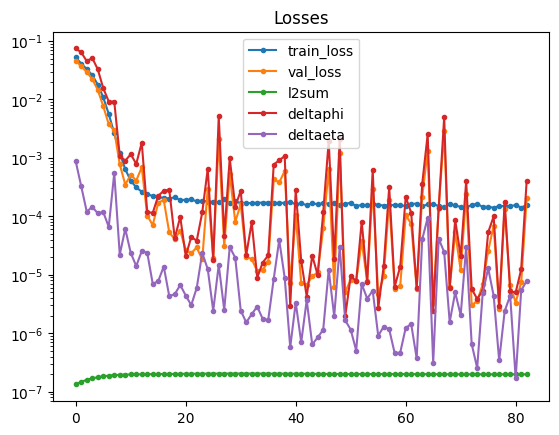

In [20]:
for col in losses_df.columns:
    plt.plot(losses_df[col], label=col, marker='.', linestyle='-')
plt.legend()
plt.yscale('log')
plt.title('Losses')
# plt.grid(True, which="both", ls="--", c='0.2')
# plt.tight_layout()
plt.show()